# Capstone Project (Wizeline Bootcamp)
## Air Quality Dataset Analysis
### Daniel Martínez Escobosa

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import yaml

import itertools
import joblib
import json

import sys
sys.path.append("..")
from src import *
from src.visualization.visualize import plot_hist_boxplot_skew_kurt_outliers
from src.visualization.visualize import plot_correlation_heatmap

In [2]:
cd ..

C:\Users\daniel.martinez\bootcamp_mlops\proyecto_ind_dme\airquality


# Config

In [3]:
# Read config
import pprint

with open('params.yaml') as conf_file:
    config = yaml.safe_load(conf_file)

pprint.pprint(config)

{'base': {'random_state': 42},
 'data_load': {'dataset_csv': 'data/raw/AirQualityUCI.csv'},
 'data_split': {'test_size': 0.2},
 'featurize': {'cols_to_drop': ['Date',
                                'Time',
                                'NMHC(GT)',
                                'C6H6(GT)',
                                'PT08.S1(CO)',
                                'PT08.S2(NMHC)',
                                'PT08.S3(NOx)'],
               'features_path': 'data/processed/AirQualityUCI_featurized.csv'},
 'reports': None,
 'train': {'cv': 3,
           'estimator_name': 'rdm_forest',
           'estimators': {'rdm_forest': {'param_grid': {'max_depth': [5, 10],
                                                        'max_features': ['sqrt'],
                                                        'min_samples_leaf': [1,
                                                                             2],
                                                        'min_samples_split': [

# <b>1. Cargando el dataset</b>

In [4]:
#Se importa dataset
raw_data = pd.read_csv(config['data_load']['dataset_csv'], sep=';', decimal=',')

#Se visualiza que figuran dos columnas extra (nulas) al extremo derecho de la matriz tabular que hay que remover
raw_data = raw_data.iloc[:, :-2]
#Procediendo a eliminar filas del dataset se asegura tener el dataset limpios de filas y columnas llenas de valores nulos y lograr la coincidencia de dimensión del dataset según la bibliografía.
raw_data = raw_data.head(9357)



# <b>2. Preprocessing (Data Prepare)</b>
## <b>2.1 Data Prepare: Feature Processing</b>

In [5]:
#Observando que la variable NMHC tiene demasiados valores faltantes (90.23% son faltantes), y ninguno de los métodos de imputación probados arrojan buenos resultados, quitamos del dataset. Nota: si más adelante no se obtienen buenos resultados con los modelos, podríamos regresar a rescatar la variable  avanzados como interpolación o modelos de machine learning. Date time también se elimina dado que no interesa en el ejercicio realizar un modelo de serie de tiempo.
#Se establece empíricamente el umbral de abs(corr)>=0.8 y se observan variables altamente correlacionada, por lo que se descartan del análisis.
cols_to_drop = config['featurize']['cols_to_drop']
trusted_data = raw_data.drop(cols_to_drop,axis='columns')
#trusted_data.head()

## <b>2.2 Data Prepare: Missing Values and Imputation</b>
Lidiando con la información faltante del dataset

In [6]:
def impute_data(dataframe):
    """
    La función toma como entrada un DataFrame de pandas y le reemplaza los valores faltantes "-200" con NaN
    y luego aplica métodos de imputación específicos a algunas columnas
    
    """
    
    # Se reemplaza valores faltantes -200 con NaN
    dataframe.replace(to_replace=-200, value=np.NaN, inplace=True)

    # Se define criterio individual (métodos de imputación) según cada variable
    imputation_methods = {
        'CO(GT)': 'median',
        'NOx(GT)': 'mean',
        'NO2(GT)': 'mean',
        'PT08.S4(NO2)': 'mean',
        'PT08.S5(O3)': 'mean',
        'T': 'mean',
        'RH': 'mean',
        'AH': 'mean'
    }

    # Se itera sobre el diccionario y se aplica el método de imputación correspondiente a cada columna
    for column, method in imputation_methods.items():
        if method == 'mean':
            mean_value = dataframe[column].mean()
            dataframe[column] = dataframe[column].fillna(mean_value)
        elif method == 'median':
            median_value = dataframe[column].median()
            dataframe[column] = dataframe[column].fillna(median_value)
        elif method == 'mode':
            mode_value = dataframe[column].mode()[0]
            dataframe[column] = dataframe[column].fillna(mode_value)
        else:
            # Imprime un error si el método de imputación no es reconocido
            print(f'Método de imputación no válido para la columna {column}: {method}')
    return dataframe

trusted_data = impute_data(trusted_data)

## <b>2.3 Dealing with Outliers</b>

In [7]:
#Tratamiento Outliers. 
#Se define función que da tratamiento a outliers previo a realizar transformaciones de datos para buscar distribuciones lo más simétricas posibles (cercanas a 0 en skew)
def remove_outliers(dataframe):
    """
    Elimina outliers de un DataFrame de pandas basado en la regla de 4 desviaciones estándar.
    
    """
    dataframe_cleaned = dataframe.copy()
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            mean = dataframe[column].mean()
            std_dev = dataframe[column].std()
            
            # Calcular límites para identificar outliers
            cut_off = std_dev * 4
            lower, upper = mean - cut_off, mean + cut_off
            
            # Filtrar outliers
            dataframe_cleaned = dataframe_cleaned[(dataframe_cleaned[column] > lower) & (dataframe_cleaned[column] < upper)]
    
    return dataframe_cleaned

# Se aplica la función al dataframe y se imprime también reporte de plots
trusted_data = remove_outliers(trusted_data)

### <b>Exploración del dataset a través de estadística descriptiva al dataset</b>

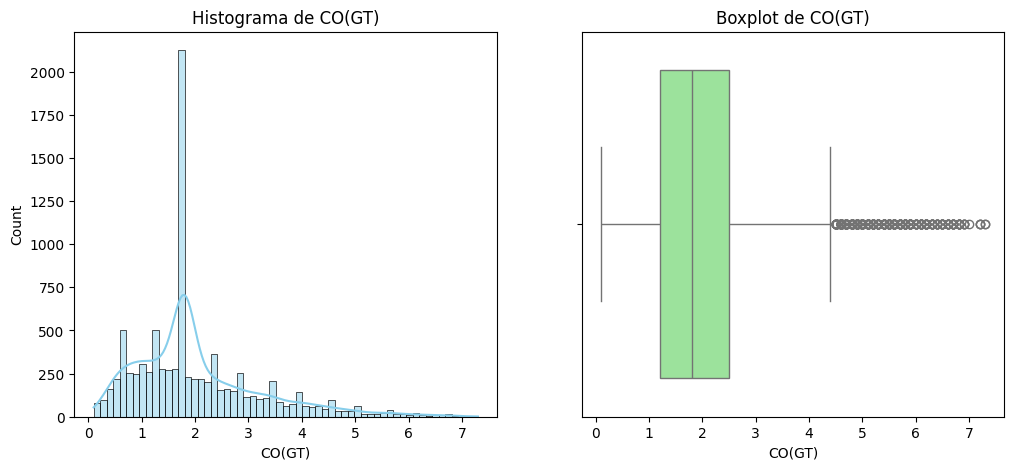

Variable: CO(GT)
Skewness: 1.23
Kurtosis: 1.70
Número de outliers: 10



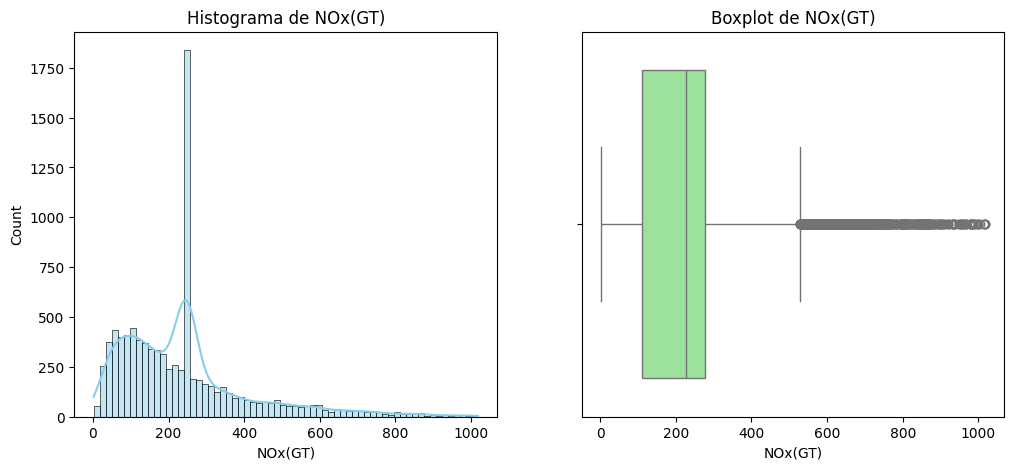

Variable: NOx(GT)
Skewness: 1.53
Kurtosis: 2.73
Número de outliers: 37



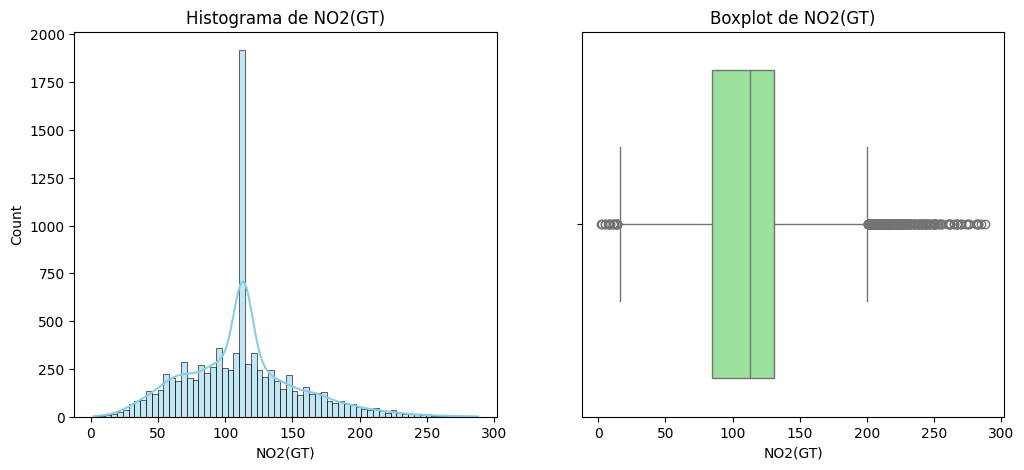

Variable: NO2(GT)
Skewness: 0.54
Kurtosis: 0.77
Número de outliers: 7



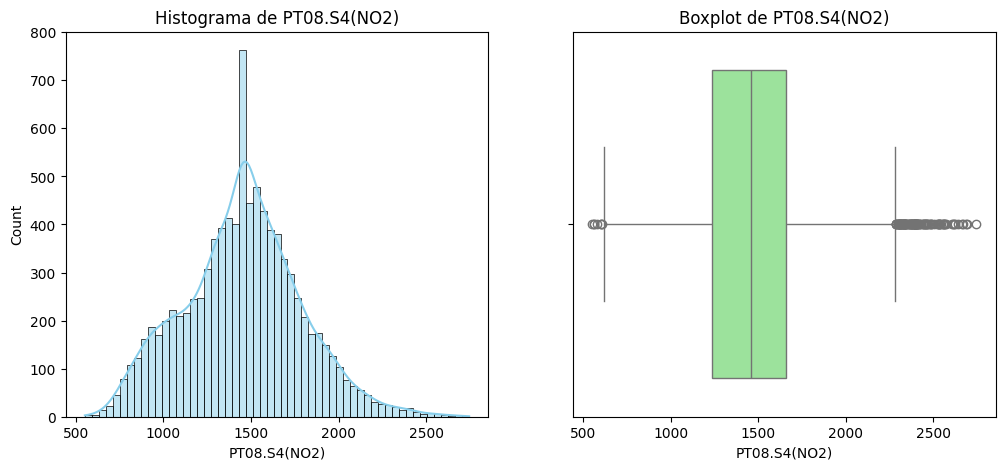

Variable: PT08.S4(NO2)
Skewness: 0.16
Kurtosis: 0.09
Número de outliers: 0



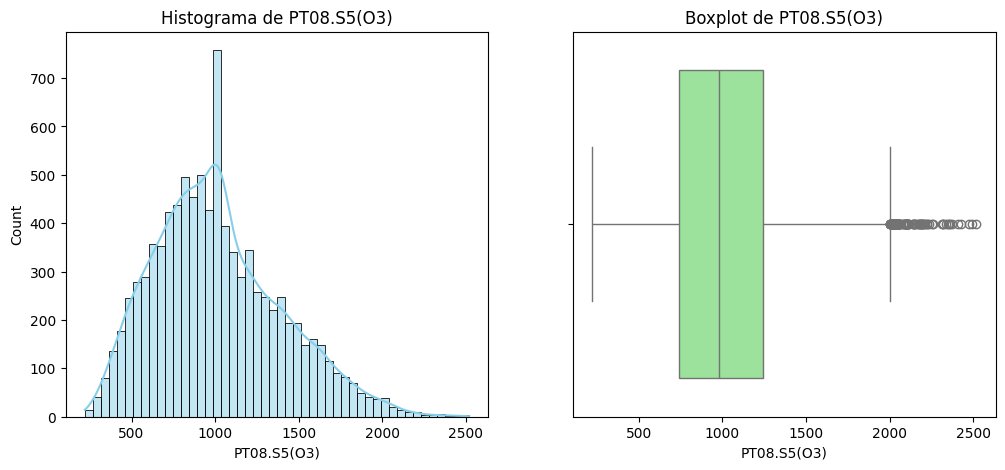

Variable: PT08.S5(O3)
Skewness: 0.56
Kurtosis: 0.02
Número de outliers: 0



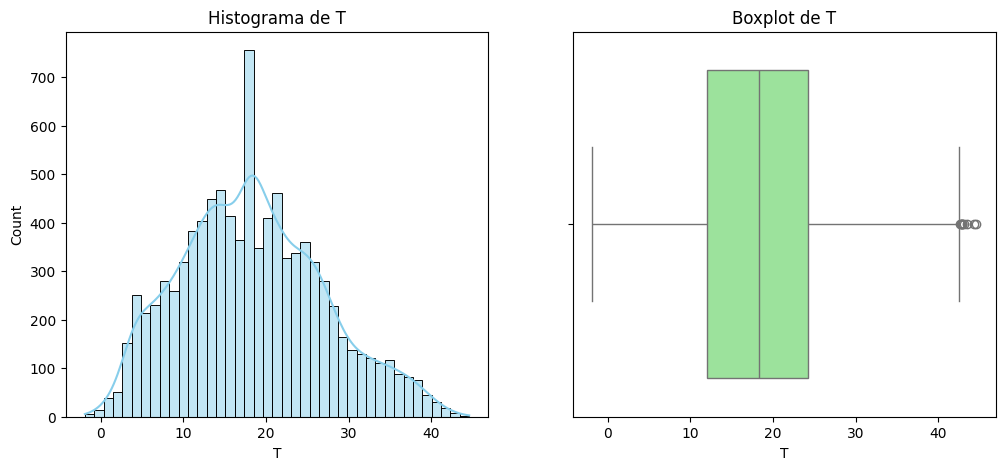

Variable: T
Skewness: 0.31
Kurtosis: -0.36
Número de outliers: 0



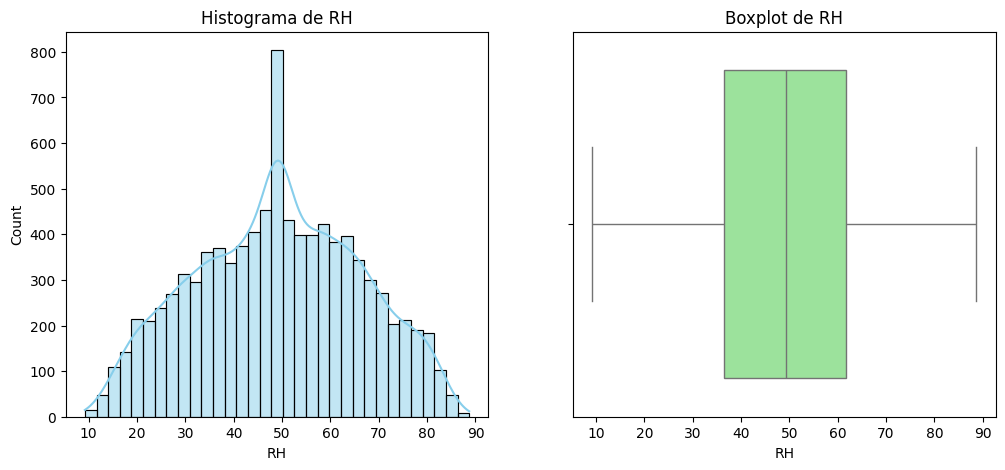

Variable: RH
Skewness: -0.03
Kurtosis: -0.74
Número de outliers: 0



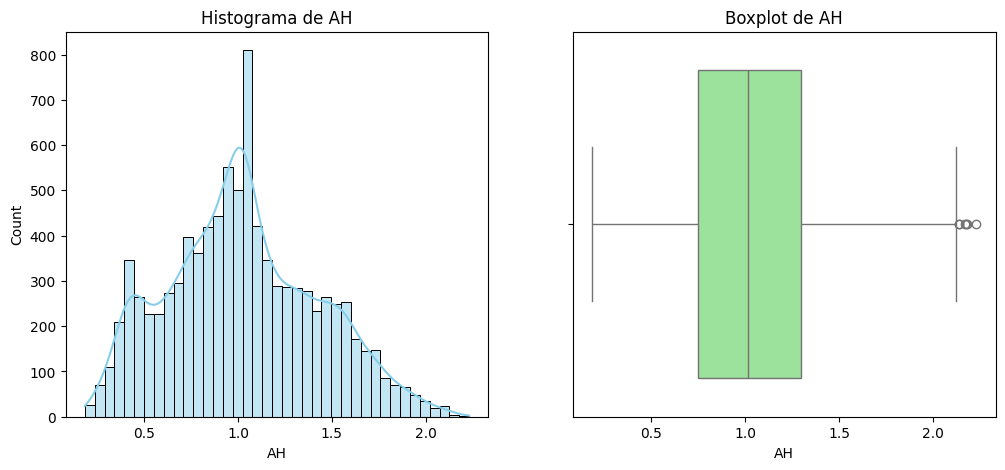

Variable: AH
Skewness: 0.25
Kurtosis: -0.46
Número de outliers: 0



In [8]:
# Graficar histogramas y boxplots, y calcular sesgo, curtosis y número de registros outliers

plot_hist_boxplot_skew_kurt_outliers(trusted_data)

### Estudiando correlaciones entre diferentes gases

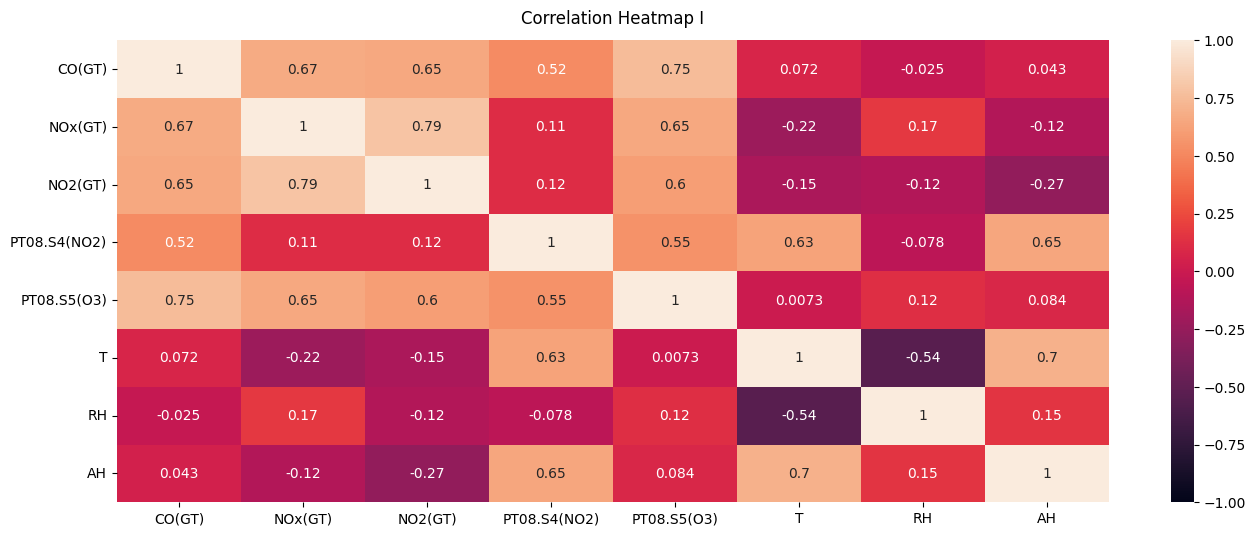

In [9]:
#Se visualizan correlaciones entre variables para estudio y entendimiento de datos
plot_correlation_heatmap(trusted_data)

## <b>2.4 Data Transformation</b>
Transformación Box-Cox.

In [10]:
#Transformaciones para mitigar sesgo
#Se propone la transformación boxcox para lidiar con el sesgo dañino previo a entrenamiento de modelos.
def transform_box_cox(dataframe):
    """
    Aplica la transformación Box-Cox a las columnas de un DataFrame
    cuyo skew sea superior a 1.25 o menor a -1.25. Imprime las variables transformadas,
    su skew antes y después de la transformación, y el valor de lambda utilizado.
    Indica si no fue necesario realizar ninguna transformación.

    Parámetros:
    - DataFrame: DataFrame de pandas con variables numéricas.

    Retorna:
    - DataFrame con las transformaciones aplicadas.
    """
    # Variable para rastrear si alguna columna fue transformada
    transformation_applied = False

    for column in trusted_data.columns:
        # Verificar que la columna sea de tipo numérico
        if pd.api.types.is_numeric_dtype(trusted_data[column]):
            skewness_before = trusted_data[column].skew()
            # Verificar el skewness de la columna
            if skewness_before > 1.25 or skewness_before < -1.25:
                # Asegurarse de que todos los valores sean positivos
                if all(trusted_data[column] > 0):
                    # Aplicar la transformación Box-Cox
                    transformed_data, best_lambda = stats.boxcox(trusted_data[column])
                    trusted_data[column] = transformed_data
                    skewness_after = trusted_data[column].skew()
                    print(f"Columna '{column}': Skew antes = {skewness_before:.2f}, Skew después = {skewness_after:.2f}, Lambda = {best_lambda:.2f}")
                    transformation_applied = True
                else:
                    print(f"La columna '{column}' contiene valores no positivos y no se transformará.")
        else:
            print(f"La columna '{column}' no es numérica y será ignorada.")

    if not transformation_applied:
        print("No fue necesario realizar ninguna transformación Box-Cox bajo el criterio de sesgo establecido.")

    return dataframe

In [11]:
# Split the data into features (X) and target variable (y) and dropping specific columns from the dataset
refined_data = trusted_data.copy()
X = refined_data.drop(columns=['CO(GT)'], axis=1)
y = refined_data['CO(GT)']

X = transform_box_cox(X)

Columna 'NOx(GT)': Skew antes = 1.53, Skew después = -0.01, Lambda = 0.26


# <b>3. Split data</b>

In [12]:
# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['data_split']['test_size'], random_state=config['base']['random_state'], shuffle=False)

# Escalado de características
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.transform(X_test)

In [13]:
print(X_train.shape, y_train.shape)

(7400, 7) (7400,)


In [14]:
print(X_test.shape, y_test.shape)

(1850, 7) (1850,)


# <b>4. Train</b>

In [15]:
# Función para encontrar los mejores parámetros con GridSearchCV
def grid_search_forest(X_train, y_train):
    param_grid = config['train']['estimators'][config['train']['estimator_name']]['param_grid']
    grid_search = GridSearchCV(RandomForestRegressor(random_state=config['base']['random_state']), param_grid, cv=config['train']['cv'], verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search


In [16]:
# Configurar y ejecutar GridSearchCV
grid_search_results = grid_search_forest(X_train_scaled, y_train)
best_forest = grid_search_results.best_estimator_
print("Best parameters found: ", grid_search_results.best_params_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


# <b>5. Evaluate Random Forest Regressor</b>

In [17]:
#Función para realizar evaluación del modelo    
def model_evaluation(estimator, X_train, y_train, X_test, y_test):
    # Entrenar el modelo
    estimator.fit(X_train, y_train)
    # Predecir los valores para los conjuntos de entrenamiento y prueba
    predicted_train_values = estimator.predict(X_train)
    predicted_test_values = estimator.predict(X_test)
    # Crear un DataFrame con las métricas de evaluación
    scores = pd.DataFrame({
        'train R2':   [r2_score(y_train, predicted_train_values)],
        'test R2':    [r2_score(y_test, predicted_test_values)],
        'train RMSE': [np.sqrt(mean_squared_error(y_train, predicted_train_values))],
        'test RMSE':  [np.sqrt(mean_squared_error(y_test, predicted_test_values))],
        'train MAE':  [mean_absolute_error(y_train, predicted_train_values)],
        'test MAE':   [mean_absolute_error(y_test, predicted_test_values)]
    })
    return scores

In [18]:
# Evaluar el mejor modelo utilizando los mejores parámetros encontrados
evaluation_results = model_evaluation(best_forest, X_train_scaled, y_train, X_test_scaled, y_test)
print(evaluation_results)

   train R2   test R2  train RMSE  test RMSE  train MAE  test MAE
0  0.915276  0.696686    0.346303   0.690434   0.243534  0.507228
